# causal-inference-clinical-trial
## Author: Yotam Dery
## Date: 07/27/2025

# Imports

In [ ]:
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import shap
import warnings
warnings.filterwarnings('ignore')


# Data Loading

In [2]:
# Loading the train data
df = pd.read_csv('simulated_data.csv')
print('df shape is: {}'.format(df.shape))
print("Data is not so big...")
# First inspect of the train set
df.head()

df shape is: (500, 17)
Data is not so big...


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,W,Y
0,0.792263,-0.244170,0.821644,2.253981,1.622495,-0.665257,1.607984,0.559728,-1.113358,0.471344,-0.978445,-0.873842,0.104097,-2.954219,-1.565851,0,-0.742286
1,5.940689,-2.736339,-0.447395,-2.142582,-0.257293,2.307737,-0.838035,-0.355448,-1.743370,-0.991666,-0.042201,-1.265765,0.498976,-0.910386,-0.264795,1,10.054229
2,4.282139,0.479162,-1.112389,-2.501579,-0.327265,-2.747114,-0.343063,-3.095397,-1.421179,0.222395,0.719102,-0.035342,-0.299285,-0.547239,-1.342177,0,-0.594755
3,1.249752,-0.013560,1.743732,0.629939,-0.582400,0.805786,-0.206782,-0.624488,0.960960,1.714601,1.155574,-0.766950,-0.370081,0.557652,0.885583,0,-0.029173
4,0.426834,0.224878,-1.203413,-1.491581,0.186331,2.714065,0.137202,1.513356,0.378006,-0.941757,0.489559,1.489267,-0.128443,2.141050,-2.378160,0,-4.438536


# EDA

In [3]:
# Number of entries and columns
num_entries, num_columns = df.shape

# Data types
feature_types = df.dtypes.value_counts()

# Check for missing values
missing_values = df.isnull().sum().sum()

print("Data types:\n", feature_types)
print(f"Missing values: {missing_values}")

Data types:
 float64    16
int64       1
Name: count, dtype: int64
Missing values: 0


In [4]:
df.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,W,Y
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,4.916628,-0.069489,0.041143,-0.022298,-0.030191,6.010672,-0.025371,-0.023803,-0.013356,0.053486,0.070283,0.071063,-0.025086,-0.047964,0.084873,0.524000,4.227549
std,7.526221,1.740764,1.650882,1.729703,1.233961,77.249412,1.439810,1.514698,1.030801,1.591128,1.204268,1.071511,1.520208,1.507001,0.884864,0.499924,5.449067
min,0.000046,-4.681556,-5.493994,-4.836415,-3.399328,-4.918772,-3.835565,-5.008116,-3.354270,-4.929876,-3.443428,-3.095682,-4.284727,-4.420096,-2.741062,0.000000,-15.731248
25%,0.543961,-1.354622,-1.067263,-1.220082,-0.827116,-1.126427,-0.941070,-0.952069,-0.737948,-1.012684,-0.750585,-0.675215,-1.133947,-1.100788,-0.486434,0.000000,0.735669
50%,2.044044,0.031393,0.096781,-0.027199,-0.069662,0.027302,-0.128451,0.052641,-0.063145,-0.036761,0.065899,0.052030,-0.073695,-0.026473,0.062372,1.000000,3.885082
75%,5.950916,1.099214,1.106844,1.079925,0.760043,1.292999,0.920602,0.944956,0.677770,1.221115,0.834144,0.833799,0.997858,1.090239,0.630181,1.000000,7.337414
max,49.944760,4.506294,4.340221,4.664592,3.958666,999.000000,4.710615,4.936022,2.940290,4.412907,4.102984,3.630529,4.274048,4.641031,3.497444,1.000000,26.108602


Feature distributions vary widely:

Most features are centered around 0, except X1 and X6 which have large means and standard deviations, especially X6 (std ≈ 77, max = 999), suggesting potential outliers.

Treatment split (W): ~52.4% treated, ~47.6% control (fairly balanced)

Outcome (Y): Mean = 4.23, Range = [-15.73, 26.11]

In [5]:
# Summary statistics for treatment and outcome
treatment_split = df['W'].value_counts(normalize=True) * 100
print("\nTreatment distribution (%):\n", treatment_split)


Treatment distribution (%):
 W
1    52.4
0    47.6
Name: proportion, dtype: float64


## Distribution of Outcome (Y)
Shows the shape and spread of the outcome variable.

In [6]:
# Distribution of Outcome (Y)
fig_y_dist = px.histogram(df, x='Y', nbins=30, title='Distribution of Outcome (Y)')
fig_y_dist.update_layout(bargap=0.1, title_x=0.5)
fig_y_dist.show()

### Insights from Outcome (Y) Distribution:

1. **Roughly Normal**: The outcome is unimodally and symmetrically distributed.
2. **Centered Around 4–5**: Matches the mean of \~4.23.
3. **Mild Right Skew**: Some higher outcome values extend the upper tail.
4. **Suitable for Regression**: Distribution supports linear or non-linear regression modeling.

## Boxplot of Y by Treatment (W)
Compares the distribution of outcomes between treated and control groups.

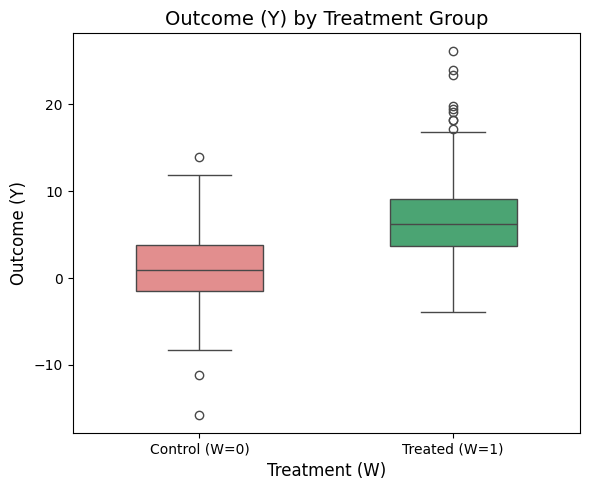

In [7]:
# Convert W to string for consistent mapping
df['W'] = df['W'].astype(str)

# Define palette with string keys
custom_palette = {'0': "lightcoral", '1': "mediumseagreen"}

# Create boxplot
plt.figure(figsize=(6, 5))
sns.boxplot(x='W', y='Y', data=df, width=0.5, palette=custom_palette)

# Labels and title
plt.title('Outcome (Y) by Treatment Group', fontsize=14)
plt.xlabel('Treatment (W)', fontsize=12)
plt.ylabel('Outcome (Y)', fontsize=12)
plt.xticks([0, 1], ['Control (W=0)', 'Treated (W=1)'])

plt.tight_layout()
plt.show()


### Insights from Boxplot (Outcome $Y$ by Treatment $W$):

1. **Higher Median** in treated group ($W=1$) → suggests a positive treatment effect.
2. **Wider Spread** and more outliers in treated group → indicates greater variability in response.
3. **Control group** ($W=0$) has a lower and more compact distribution.

This supports the presence of **heterogeneous treatment effects**, motivating modeling $\tau(X)$.


## Correlation plot
Helps identify multicollinearity and relationships among features and the outcome.

In [8]:
# Correlation Heatmap
corr = df.corr().round(2)
fig_heatmap = ff.create_annotated_heatmap(
    z=corr.values,
    x=list(corr.columns),
    y=list(corr.index),
    annotation_text=corr.values.round(2),
    colorscale='bluered',
    showscale=True,
    zmin=-1,
    zmax=1
)
fig_heatmap.update_layout(title_text='Correlation Heatmap of Features', title_x=0.5)
fig_heatmap.show()

### Correlation Heatmap Insights:

1. **Strong positive correlation**: `X5` ↔ `X7` and `X6` ↔ `X7` (≈ 0.97) → possible redundancy.
2. **Treatment (W)** moderately correlates with outcome (`Y`, r ≈ 0.53) → treatment has impact.
3. Most other features have **weak correlations** with `Y` (r < 0.3) → minimal direct linear effect.
4. **Multicollinearity alert**: Consider removing or combining `X5`, `X6`, `X7`.

## Check features balance
This code plots the **distribution (density)** of each feature `X1` to `X15` separately for the **treatment (`W=1`)** and **control (`W=0`)** groups to check if the features are **balanced** (i.e., similarly distributed across groups).

In essence, it's a **Treatment Balance Check** using KDE (Kernel Density Estimate) plots. If curves overlap closely → the feature is balanced. If not → potential confounding.

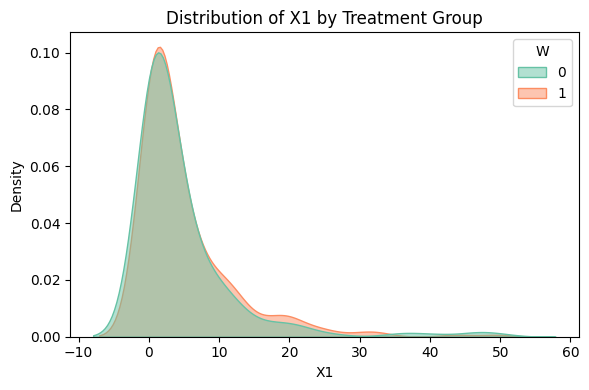

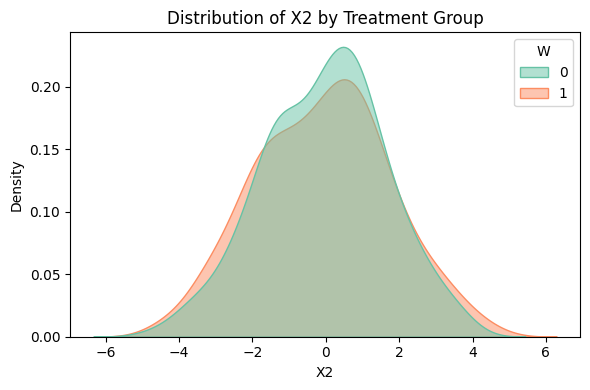

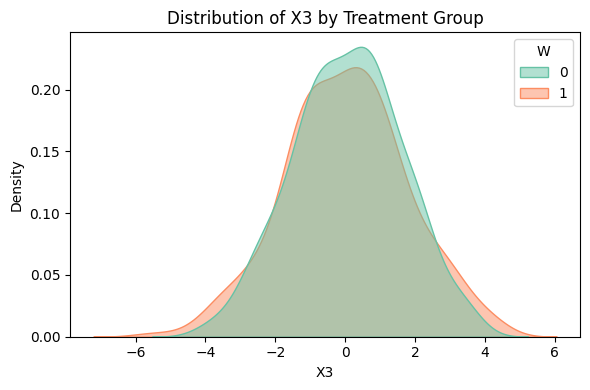

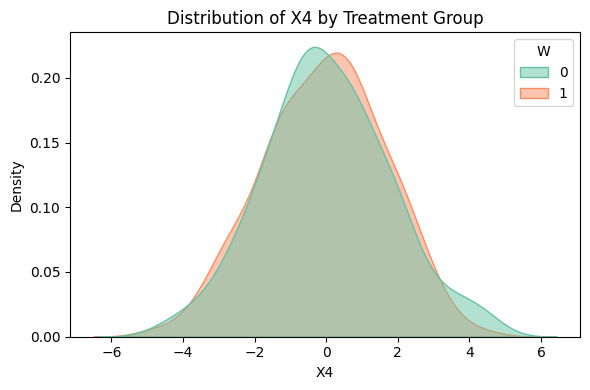

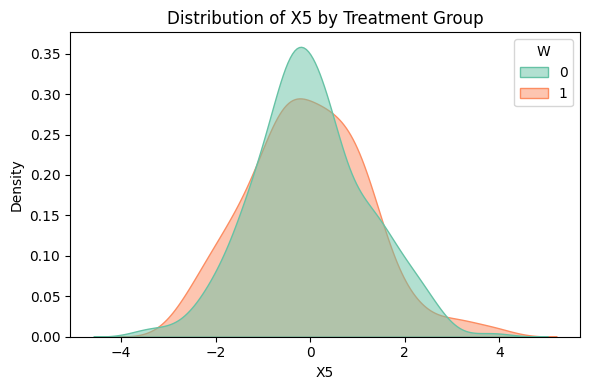

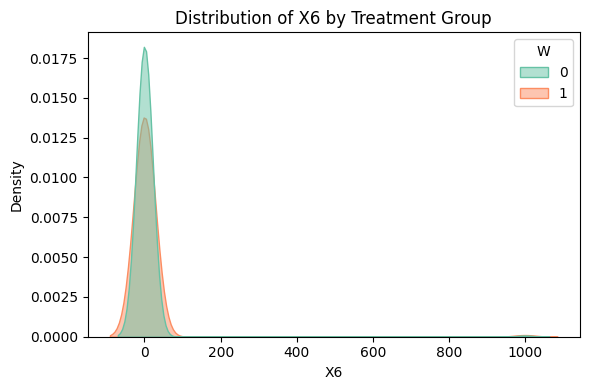

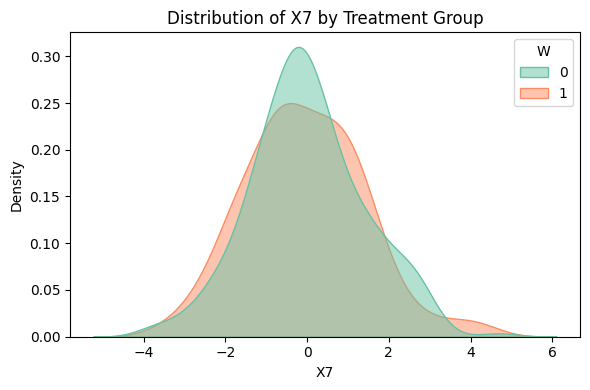

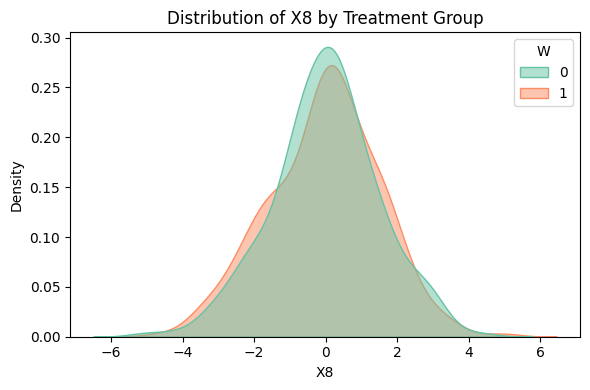

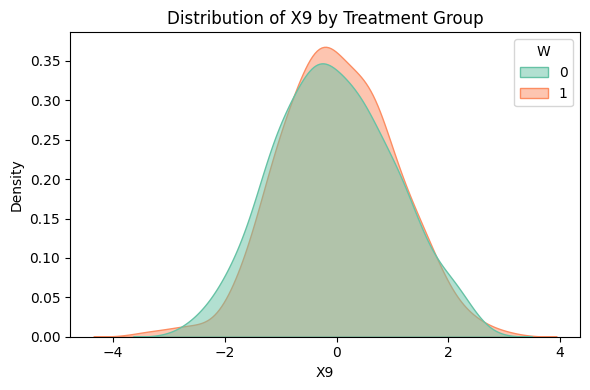

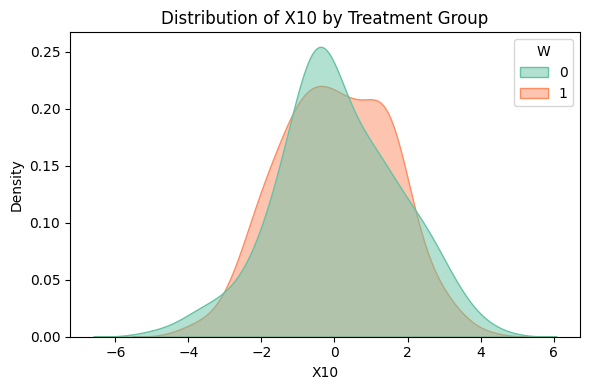

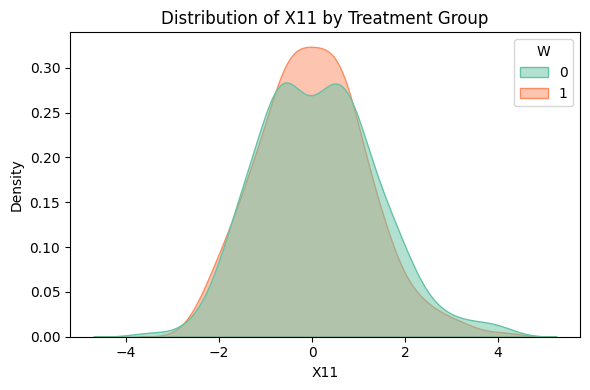

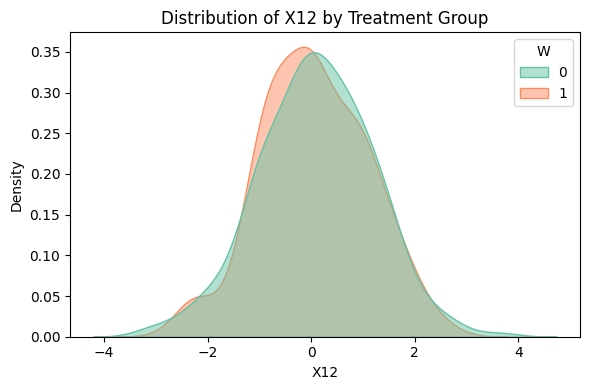

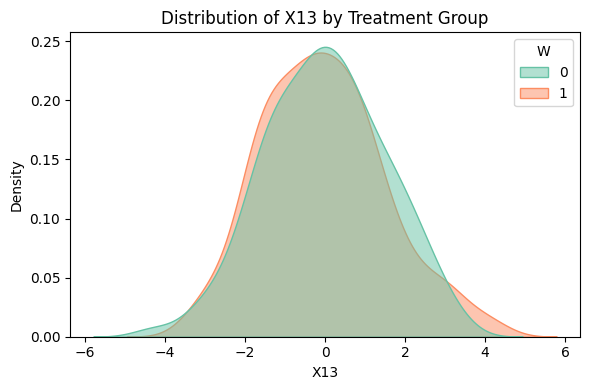

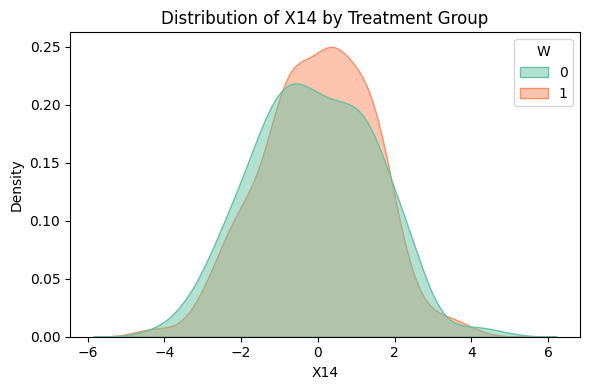

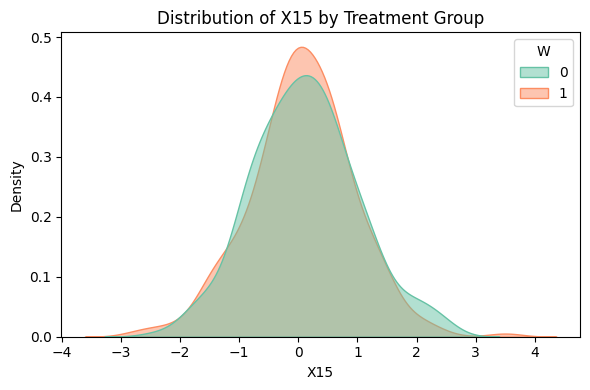

In [9]:
features = [f'X{i}' for i in range(1, 16)]

for col in features:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df, x=col, hue='W', common_norm=False, fill=True, palette='Set2', alpha=0.5)
    plt.title(f'Distribution of {col} by Treatment Group')
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()


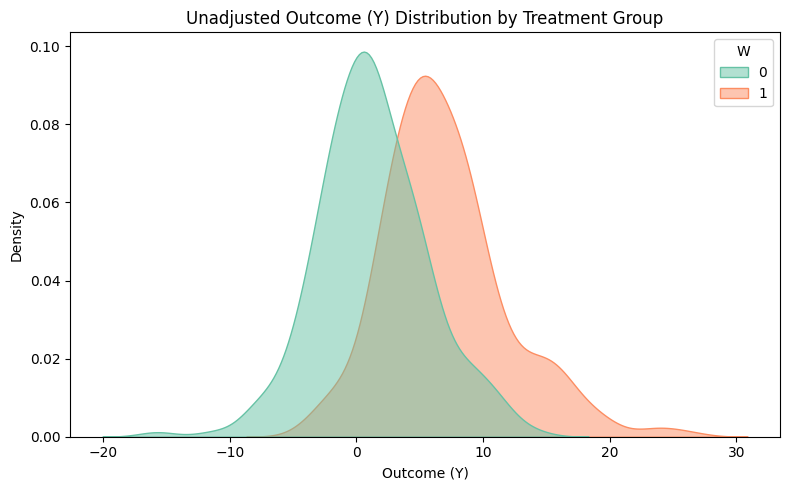

In [10]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='Y', hue='W', fill=True, common_norm=False, palette='Set2', alpha=0.5)
plt.title('Unadjusted Outcome (Y) Distribution by Treatment Group')
plt.xlabel('Outcome (Y)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

* From these plots, we'll assume that the features are balanced

## Estimate propensity scores
* propensity scores: The probability of receiving the treatment (W=1) given the covariates (X)<br><br>
We do it to adjust for confounding and prepare for causal effect estimation (matching, IPW, etc.)<br>
This enables valid causal effect estimation

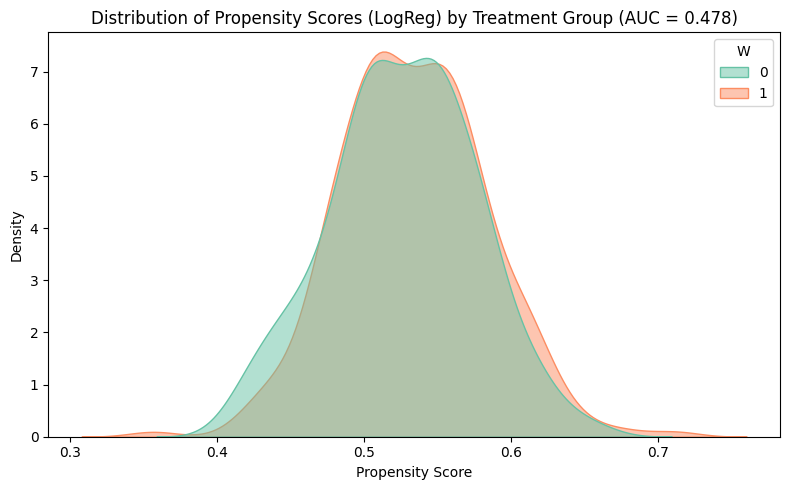

In [11]:
# Prepare data
X = df[[f'X{i}' for i in range(1, 16)]]
y = df['W'].astype(int)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train logistic regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

# Predict propensity scores
df['propensity_score_logreg'] = log_reg.predict_proba(X_scaled)[:, 1]

# Evaluate AUC
logreg_preds = log_reg.predict_proba(X_test)[:, 1]
logreg_auc = roc_auc_score(y_test, logreg_preds)

# Plot KDE
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='propensity_score_logreg', hue='W', fill=True, common_norm=False, palette='Set2', alpha=0.5)
plt.title(f'Distribution of Propensity Scores (LogReg) by Treatment Group (AUC = {logreg_auc:.3f})')
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


In [12]:
df['propensity_score_logreg']

0      0.566152
1      0.506885
2      0.506186
3      0.504853
4      0.586067
         ...   
495    0.513694
496    0.619746
497    0.495926
498    0.615486
499    0.557053
Name: propensity_score_logreg, Length: 500, dtype: float64

**Insights**
* **Good overlap** between treatment and control groups → Both treated (W=1) and control (W=0) groups have similar ranges of propensity scores.
* **AUC = 0.478** → treatment isn't predictable from features → good covariate balance (The treatment is not confounded, model doesn’t have to do much “adjusting” to make the groups comparable).
* **Scores center around 0.5** → treatment was assigned fairly evenly across covariates.

* This is ideal for causal inference.

**Inverse Probability Weights (IPW)**
* So after I estimated the probability of treatment using `Propensity scores`, I calculate `IPW`.
* **IPW** uses these scores to **reweight the data** so that treated and control groups are statistically similar (simulate a randomized experiment).
* This allows us to **unbiasedly estimate the Average Treatment Effect (ATE)** by adjusting for confounding (even if mild) due to observed covariates.

So, IPW is a **direct application** of propensity scores for causal inference.

I chose IPW over other methods because:
* Our propensity scores showed good overlap and low AUC (≈ 0.48) → indicates treatment assignment is nearly random, which is ideal for IPW.
* IPW is simple and interpretable: it directly uses estimated probabilities to reweight samples.
* Unlike matching, it retains all samples and doesn't discard data.
* It’s a standard approach when we have well-estimated propensity scores and want a quick, global estimate of ATE.


In [13]:
# Inverse Probability Weights
df['W'] = df['W'].astype(int)  # Ensure W is int for math
df['ipw_weight'] = df['W'] / df['propensity_score_logreg'] + \
                   (1 - df['W']) / (1 - df['propensity_score_logreg'])

# Apply IPW estimator
df['ipw_Y'] = df['Y'] * df['ipw_weight']

# ATE via IPW (Horvitz–Thompson estimator)
ate_ipw = (df['Y'] * df['W'] / df['propensity_score_logreg']).mean() - \
          (df['Y'] * (1 - df['W']) / (1 - df['propensity_score_logreg'])).mean()

print(f"Estimated ATE using IPW: {ate_ipw:.4f}")


Estimated ATE using IPW: 5.6959


An IPW-estimated ATE of 5.6959 suggests that the treatment increases the outcome 
𝑌 by approximately 5.70 units on average compared to the control.

This aligns with your earlier observations that:
* The treated group had a higher median outcome.
* Covariate balance was already good.
* Treatment assignment appeared close to random (AUC ≈ 0.48).

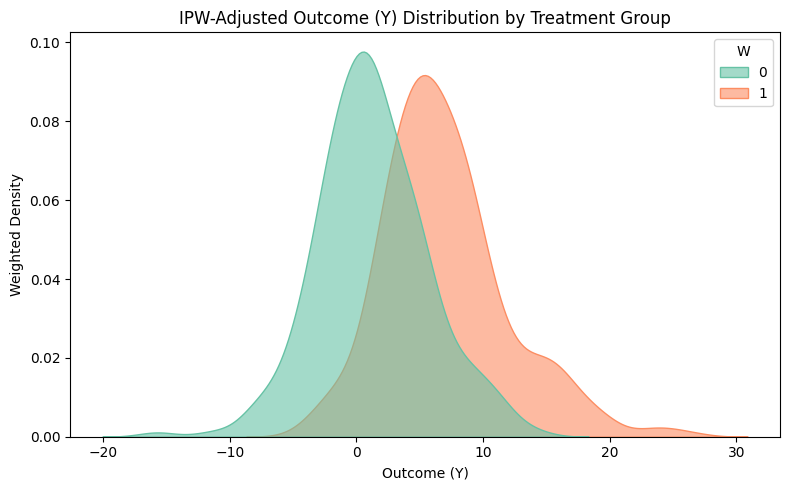

In [14]:
# Add weights to the dataframe
df['ipw_weight'] = df['W'].astype(int) / df['propensity_score_logreg'] + \
                   (1 - df['W'].astype(int)) / (1 - df['propensity_score_logreg'])

# Plot IPW-adjusted KDEs of the outcome
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df, x='Y', hue='W', weights='ipw_weight', fill=True, common_norm=False, palette='Set2', alpha=0.6)
plt.title('IPW-Adjusted Outcome (Y) Distribution by Treatment Group')
plt.xlabel('Outcome (Y)')
plt.ylabel('Weighted Density')
plt.tight_layout()
plt.show()


* The separation between treated and control outcomes persists after IPW adjustment, suggesting the treatment effect is likely causal, not just due to covariate imbalances.

In [22]:
# Remove outliers from X6 using IQR
Q1 = df['X6'].quantile(0.25)
Q3 = df['X6'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers in X6
df = df[(df['X6'] >= lower_bound) & (df['X6'] <= upper_bound)]

# Show shape before and after
df.shape, df.shape


((494, 23), (494, 23))

# 1. Identify the features that contribute to the prognostic function, 𝑔(𝑋)and to the predictive function τ(𝑋)

Let's start with the prognostic function: <br>
Estimate the Prognostic Function 𝑔(𝑋)
Predict outcome Y using only control group (W=0).

Fit a model (e.g., Linear Regression, XGBoost) on X to predict Y for W=0.

Feature importance in this model identifies contributors to 𝑔(𝑋).

In [ ]:
df['W'] = df['W'].astype(str)
df_control = df[df['W'] == '0'].copy()

# Define features and target
features = [f'X{i}' for i in range(1, 16)]
X_control = df_control[features]
y_control = df_control['Y']

# Fit XGBoost model to predict Y from X
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_control, y_control)

# Get feature importances
importances = pd.Series(xgb_reg.feature_importances_, index=features).sort_values(ascending=False)
importances

X5     0.246864
X4     0.181200
X2     0.092508
X1     0.064420
X6     0.058056
X3     0.056688
X14    0.054038
X7     0.050451
X10    0.034301
X11    0.033556
X15    0.031925
X8     0.031310
X13    0.027770
X12    0.020975
X9     0.015938
dtype: float32

X5 and X4 are the strongest prognostic factors for outcome 
𝑌
Y in the control group.

X2 and X1 also show moderate influence.

Most other features have minimal contribution.

These features predict baseline outcomes independent of treatment.

Let's move to the predictive function:

### Estimate the Predictive Function **τ(𝑋)**

τ(𝑋) captures **how the treatment effect varies** across individuals.

Use a **T-Learner**:

* Train two models:

  * One on the treated group (W=1) → predict $\hat{Y}_1(X)$
  * One on the control group (W=0) → predict $\hat{Y}_0(X)$
* Compute τ(𝑋) as the difference:

  $$
  \hat{\tau}(X) = \hat{Y}_1(X) - \hat{Y}_0(X)
  $$
* Fit a model on τ(𝑋) using X to find which features **drive variation** in treatment effect.
  Feature importance reveals contributors to **treatment effect heterogeneity**.


In [ ]:
# Separate treated and control groups
df['W'] = df['W'].astype(int)
df_treated = df[df['W'] == 1]
df_control = df[df['W'] == 0]

X_treated = df_treated[features]
y_treated = df_treated['Y']

X_control = df_control[features]
y_control = df_control['Y']

# Train separate models for treated and control
model_treated = XGBRegressor(random_state=42)
model_control = XGBRegressor(random_state=42)

model_treated.fit(X_treated, y_treated)
model_control.fit(X_control, y_control)

# Predict potential outcomes for all samples
X_all = df[features]
df['Y1_hat'] = model_treated.predict(X_all)
df['Y0_hat'] = model_control.predict(X_all)

# Estimate individual treatment effects
df['tau_hat'] = df['Y1_hat'] - df['Y0_hat']

# Train XGBoost on tau_hat to find influential features
tau_model = XGBRegressor(random_state=42)
tau_model.fit(X_all, df['tau_hat'])

tau_importances = pd.Series(tau_model.feature_importances_, index=features).sort_values(ascending=False)
tau_importances

X5     0.225001
X6     0.115911
X3     0.087646
X12    0.083861
X14    0.083265
X4     0.069911
X9     0.060272
X10    0.055917
X2     0.043900
X7     0.036452
X15    0.035134
X8     0.032946
X13    0.027670
X1     0.021341
X11    0.020774
dtype: float32

* X5 and X6 are again the most influential predictors of treatment effect heterogeneity

# 2.Estimate the contributions of these covariates to each function

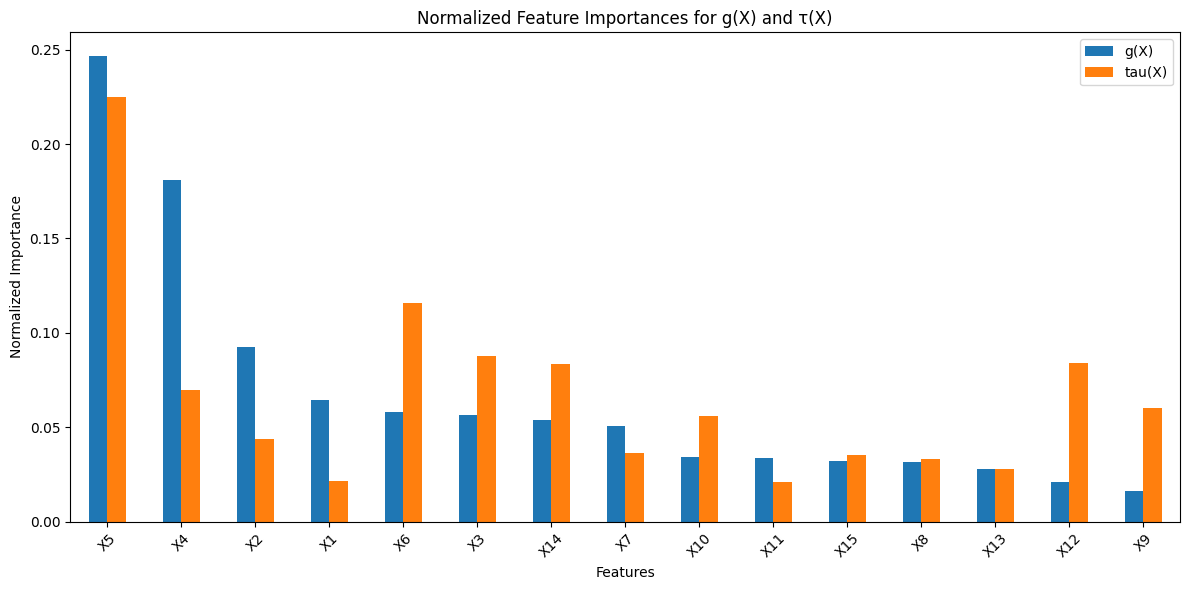

In [23]:
# Normalize importances
gX_normalized = importances / importances.sum()
tauX_normalized = tau_importances / tau_importances.sum()

# Combine into a single DataFrame for comparison
importance_df = pd.DataFrame({
    'g(X)': gX_normalized,
    'tau(X)': tauX_normalized
}).sort_values('g(X)', ascending=False)

# Plot the contributions
importance_df.plot(kind='bar', figsize=(12, 6))
plt.title('Normalized Feature Importances for g(X) and τ(X)')
plt.ylabel('Normalized Importance')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


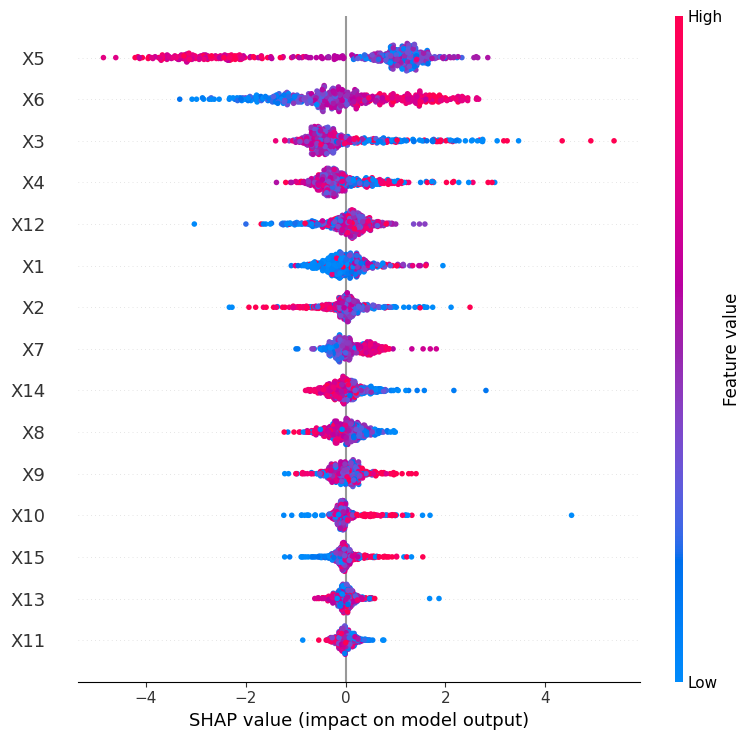

In [ ]:
# Initialize the SHAP explainer for tree models
explainer = shap.Explainer(tau_model)

# Compute SHAP values for all samples
shap_values = explainer(X_all)

# Summary plot (global interpretation)
shap.summary_plot(shap_values, X_all)

Interpretation: <br>
Both methods (SHAP & feature importance) agree on which features drive heterogeneity in treatment effect.

SHAP adds extra interpretability by showing the direction and range of influence at the individual level, unlike XGBoost’s aggregated scores.